Confirmed by Omar

used car  Price prediction
the dataset: https://www.kaggle.com/datasets/jpayne/852k-used-car-listings/code
Musab


In [ ]:
!pip install kagglehub


In [ ]:
!nvidia-smi

Wed Apr 16 20:49:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import kagglehub
path = kagglehub.dataset_download('jpayne/852k-used-car-listings')

print('Data source import complete.',path)


Data source import complete. /kaggle/input/852k-used-car-listings


In [ ]:
# prompt: import OS

import os
os.listdir('/kaggle/input/852k-used-car-listings')


['tc20171021.csv', 'true_car_listings.csv']

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, confusion_matrix
import cudf
import cuml
from cuml.linear_model import LogisticRegression
from cuml.model_selection import train_test_split
from cuml.preprocessing import StandardScaler
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, confusion_matrix
import cudf
import cuml
from cuml.linear_model import LogisticRegression
from cuml.model_selection import train_test_split
from cuml.preprocessing import StandardScaler
from cuml.ensemble import RandomForestClassifier
import joblib
import xgboost as xgb

In [ ]:
for dirname, _, filenames in os.walk('tc20171021.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:
# Load the dataset into a cuDF DataFrame
gdf = cudf.read_csv("/kaggle/input/852k-used-car-listings/tc20171021.csv")

# Display the first few rows of the dataset
print(gdf.head())


   Id  Price  Year  Mileage            City State                Vin   Make  \
0   1  16472  2015    18681  Jefferson City    MO  KL4CJBSBXFB267643  Buick   
1   2  15749  2015    27592        Highland    IN  KL4CJASB5FB245057  Buick   
2   3  16998  2015    13650           Boone    NC  KL4CJCSB0FB264921  Buick   
3   4  15777  2015    25195     New Orleans    LA  KL4CJASB4FB217542  Buick   
4   5  16784  2015    22800       Las Vegas    NV  KL4CJBSB3FB166881  Buick   

               Model  
0  EncoreConvenience  
1          EncoreFWD  
2      EncoreLeather  
3          EncoreFWD  
4  EncoreConvenience  


In [ ]:
# exploration
print("\nDataset shape:", gdf.shape)
print("\nSample of the data:")
print(gdf.head())
print("\nClass distribution:")



Dataset shape: (1233042, 9)

Sample of the data:
   Id  Price  Year  Mileage            City State                Vin   Make  \
0   1  16472  2015    18681  Jefferson City    MO  KL4CJBSBXFB267643  Buick   
1   2  15749  2015    27592        Highland    IN  KL4CJASB5FB245057  Buick   
2   3  16998  2015    13650           Boone    NC  KL4CJCSB0FB264921  Buick   
3   4  15777  2015    25195     New Orleans    LA  KL4CJASB4FB217542  Buick   
4   5  16784  2015    22800       Las Vegas    NV  KL4CJBSB3FB166881  Buick   

               Model  
0  EncoreConvenience  
1          EncoreFWD  
2      EncoreLeather  
3          EncoreFWD  
4  EncoreConvenience  

Class distribution:


### **Data Visualization**

> Add blockquote



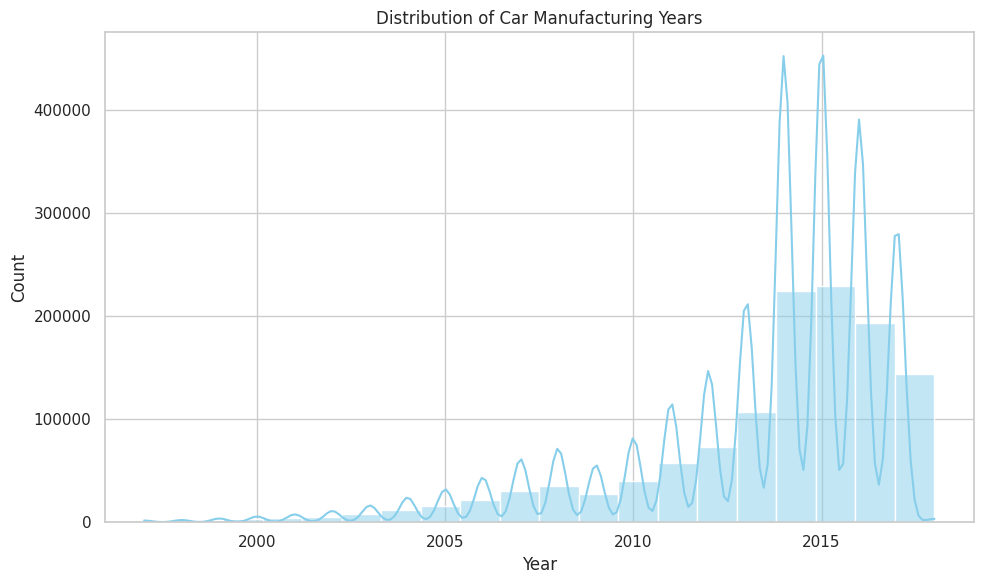

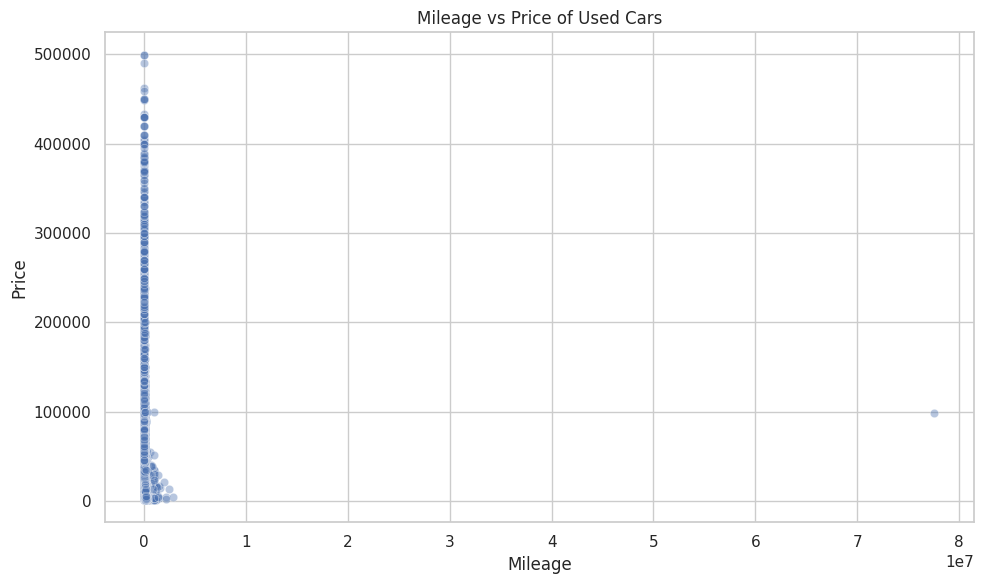

<ipython-input-9-b08ae9b45dc9>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Make', y='Price', data=pdf[pdf['Make'].isin(top_makes)], palette='Set2')


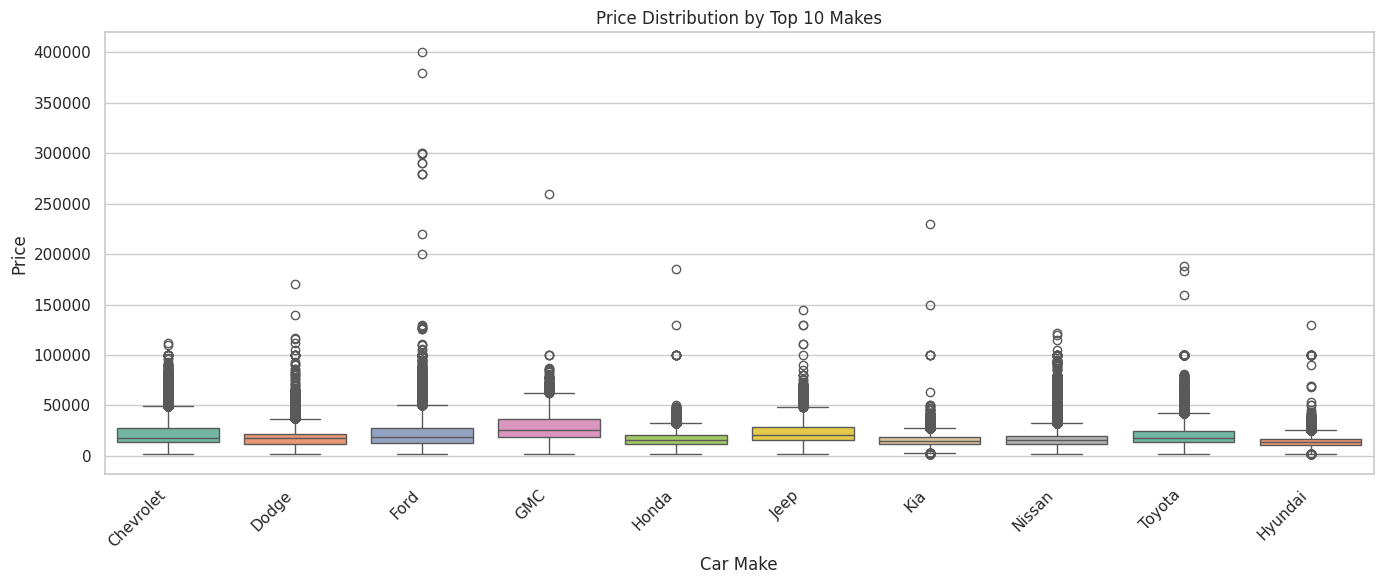

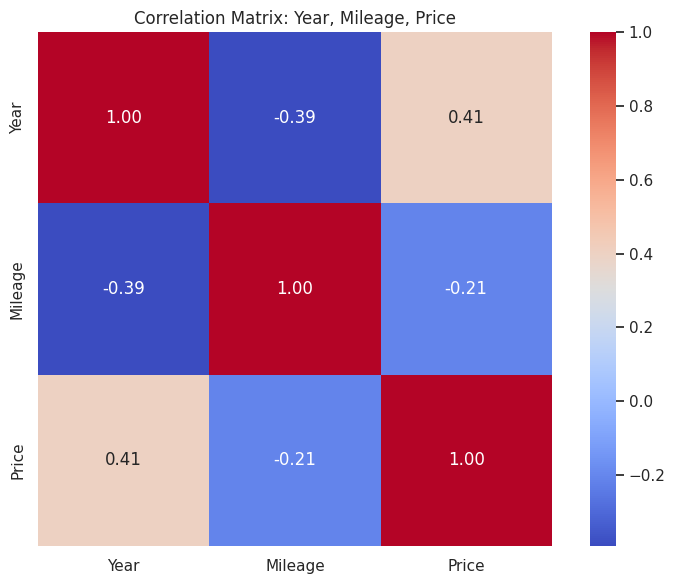

<ipython-input-9-b08ae9b45dc9>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Make', data=pdf[pdf['Make'].isin(top_makes_count)], palette='viridis')


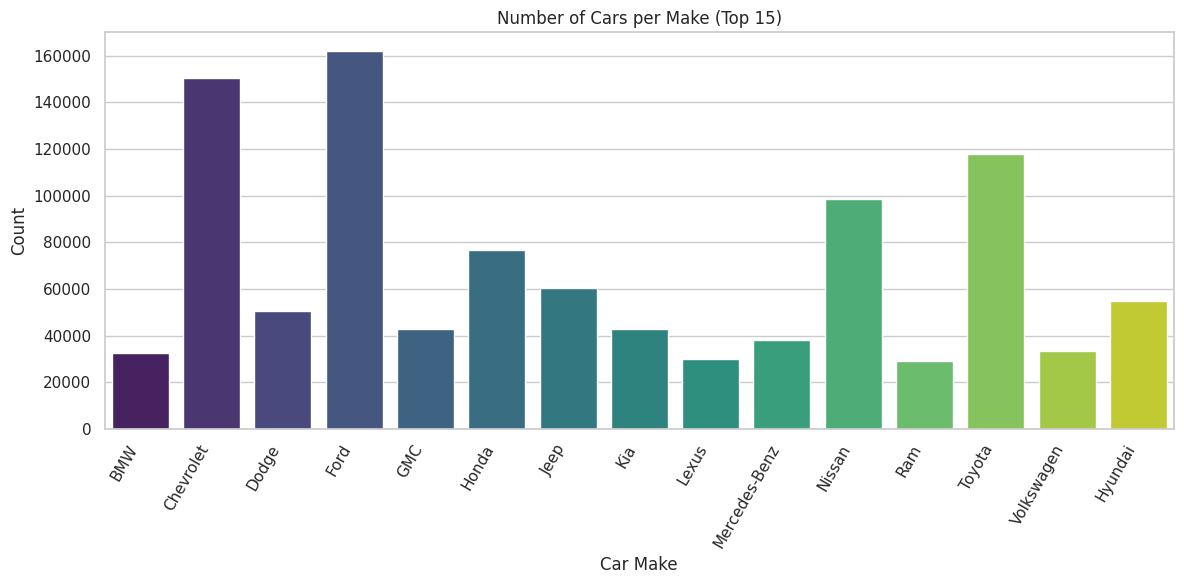

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert cuDF to pandas for visualization
pdf = gdf.to_pandas()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(pdf['Year'], kde=True, color='skyblue', bins=20)
plt.title('Distribution of Car Manufacturing Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Mileage', y='Price', data=pdf, alpha=0.4)
plt.title('Mileage vs Price of Used Cars')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
top_makes = pdf['Make'].value_counts().nlargest(10).index  # Top 10 makes
sns.boxplot(x='Make', y='Price', data=pdf[pdf['Make'].isin(top_makes)], palette='Set2')
plt.title('Price Distribution by Top 10 Makes')
plt.xlabel('Car Make')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
corr = pdf[['Year', 'Mileage', 'Price']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix: Year, Mileage, Price')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
top_makes_count = pdf['Make'].value_counts().nlargest(15).index
sns.countplot(x='Make', data=pdf[pdf['Make'].isin(top_makes_count)], palette='viridis')
plt.title('Number of Cars per Make (Top 15)')
plt.xticks(rotation=60, ha='right')
plt.xlabel('Car Make')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


### PreProssing

In [ ]:
gdf = gdf.drop('Vin', axis=1)
gdf = gdf.drop('Id', axis=1)

In [ ]:
print(gdf.head())

   Price  Year  Mileage            City State   Make              Model
0  16472  2015    18681  Jefferson City    MO  Buick  EncoreConvenience
1  15749  2015    27592        Highland    IN  Buick          EncoreFWD
2  16998  2015    13650           Boone    NC  Buick      EncoreLeather
3  15777  2015    25195     New Orleans    LA  Buick          EncoreFWD
4  16784  2015    22800       Las Vegas    NV  Buick  EncoreConvenience


In [ ]:
print("\nNull values per column:")
print(gdf.isnull().sum())


Null values per column:
Price      0
Year       0
Mileage    0
City       0
State      0
Make       0
Model      0
dtype: int64


In [ ]:


print(gdf[['Mileage', 'Year', 'Price']].head(200))


     Mileage  Year  Price
0      18681  2015  16472
1      27592  2015  15749
2      13650  2015  16998
3      25195  2015  15777
4      22800  2015  16784
..       ...   ...    ...
195    21192  2016  17494
196    36760  2014  14992
197    49851  2014  13687
198    22787  2015  16991
199    22686  2015  15997

[200 rows x 3 columns]


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import joblib
import cudf

# Convert cuDF to pandas
gdf_pandas = gdf.to_pandas()

# Fit OrdinalEncoder on specific columns
encoder = OrdinalEncoder()
gdf_pandas[['State', 'Make', 'Model', 'City']] = encoder.fit_transform(
    gdf_pandas[['State', 'Make', 'Model', 'City']]
)

# Save the encoder for future use (e.g., Gradio app)
joblib.dump(encoder, '/content/ordinal_encoder.joblib')

# Optional: Convert back to cuDF
gdf = cudf.DataFrame.from_pandas(gdf_pandas)

print("✅ OrdinalEncoder fitted and saved as 'ordinal_encoder.joblib'")


✅ OrdinalEncoder fitted and saved as 'ordinal_encoder.joblib'


In [ ]:
# prompt: print 200 row of mileage and year and price

print(gdf[['Mileage', 'Year', 'Price']].head(200))


     Mileage  Year  Price
0      18681  2015  16472
1      27592  2015  15749
2      13650  2015  16998
3      25195  2015  15777
4      22800  2015  16784
..       ...   ...    ...
195    21192  2016  17494
196    36760  2014  14992
197    49851  2014  13687
198    22787  2015  16991
199    22686  2015  15997

[200 rows x 3 columns]


In [ ]:
X = gdf.drop('Price', axis=1)
y = gdf['Price']


In [ ]:
X

,Year,Mileage,City,State,Make,Model
0,2015,18681,1085.0,28.0,7.0,893.0
1,2015,27592,1005.0,19.0,7.0,895.0
2,2015,13650,217.0,32.0,7.0,896.0
3,2015,25195,1588.0,22.0,7.0,895.0
4,2015,22800,1201.0,38.0,7.0,893.0
...,...,...,...,...,...,...
1233037,2017,25,624.0,36.0,56.0,2939.0
1233038,2017,10,484.0,5.0,56.0,2939.0
1233039,2018,2500,688.0,36.0,56.0,2938.0
1233040,2017,3201,688.0,36.0,56.0,2938.0


In [ ]:
y

0          16472
1          15749
2          16998
3          15777
4          16784
           ...  
1233037    79900
1233038    80895
1233039    68755
1233040    72260
1233041    60240
Name: Price, Length: 1233042, dtype: int64

In [ ]:
X = cudf.DataFrame.from_pandas(X)
y = cudf.Series.from_pandas(y)

/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:5571: FutureWarning: Support for loading dataframes via the `__dataframe__` interchange protocol is deprecated
  warnings.warn(


In [ ]:
from cuml.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
joblib.dump(scaler, 'scaler.joblib')


['scaler.joblib']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


### **XGboost Model**

In [ ]:
import time
import tracemalloc
import numpy as np
import xgboost as xgb

y_test_np = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test

# ✅ Use GPU training (XGBoost 2.0+ syntax)
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=400,
    max_depth=10,
    tree_method='hist',
    device='cuda',
    random_state=511
)


tracemalloc.start()
start_time = time.time()

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

execution_time = time.time() - start_time
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Evaluation
mse = np.mean((y_pred - y_test_np) ** 2)
rmse = np.sqrt(mse)
r2 = 1 - (np.sum((y_pred - y_test_np) ** 2) / np.sum((y_test_np - np.mean(y_test_np)) ** 2))

# Output
print(f"Execution Time: {execution_time:.2f} seconds")
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.4f}")
joblib.dump(xgb_model, 'xgb_model.joblib')
tracemalloc.stop()


Execution Time: 4.70 seconds
Current memory usage: 1.57 MB; Peak: 19.66 MB
Mean Squared Error (MSE): 19724623.70
Root Mean Squared Error (RMSE): 4441.24
R-squared (R2): 0.8853


### **RandomForest**

In [ ]:
from cuml.ensemble import RandomForestRegressor
from cuml.metrics import mean_squared_error, r2_score
import time
import tracemalloc
import joblib

start_time = time.time()
tracemalloc.start()

model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred_rf = model.predict(X_test)

end_time = time.time()
execution_time = end_time - start_time
current, peak = tracemalloc.get_traced_memory()

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf**0.5
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Execution Time: {execution_time:.2f} seconds")
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R-squared (R2): {r2_rf}")

# Save the trained model
joblib.dump(model, 'random_forest_regressor_model.joblib')

tracemalloc.stop()


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Execution Time: 8.44 seconds
Current memory usage: 0.10 MB; Peak: 0.48 MB
Mean Squared Error (MSE): 79566958.4587983
Root Mean Squared Error (RMSE): 8920.031303689371
R-squared (R2): 0.5374691379973282


In [ ]:

from cuml.svm import SVR


start_time = time.time()
tracemalloc.start()

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_test)

end_time = time.time()
execution_time = end_time - start_time
current, peak = tracemalloc.get_traced_memory()

mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = mse_svr**0.5
r2_svr = r2_score(y_test, y_pred_svr)

print(f"Execution Time: {execution_time:.2f} seconds")
print(f"Current memory usage: {current / 10**6:.2f} MB; Peak: {peak / 10**6:.2f} MB")
print(f"Mean Squared Error (MSE): {mse_svr}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr}")
print(f"R-squared (R2): {r2_svr}")

joblib.dump(svr_model, 'svr_model.joblib')

tracemalloc.stop()


Execution Time: 30.75 seconds
Current memory usage: 0.08 MB; Peak: 0.45 MB
Mean Squared Error (MSE): 143426316.4623811
Root Mean Squared Error (RMSE): 11976.072664374624
R-squared (R2): 0.1662481629033853


In [ ]:
# prompt: print bolt for best accuracy model

print(f"R-squared (R2) for XGBoost: {r2:.4f}")
print(f"R-squared (R2) for RandomForest: {r2_rf}")
print(f"R-squared (R2) for SVR: {r2_svr}")

# Determine the best model based on R-squared
best_model = "XGBoost"
best_r2 = r2
if r2_rf > best_r2:
    best_model = "RandomForest"
    best_r2 = r2_rf
if r2_svr > best_r2:
    best_model = "SVR"
    best_r2 = r2_svr

print(f"\nThe best model is {best_model} with an R-squared of {best_r2:.4f}")


R-squared (R2) for XGBoost: 0.8853
R-squared (R2) for RandomForest: 0.5374691379973282
R-squared (R2) for SVR: 0.1662481629033853

The best model is XGBoost with an R-squared of 0.8853


In [ ]:
!pip install -q gradio

UI Grido

In [ ]:
# Install needed packages if on Colab
# !pip install -q gradio joblib cudf cuml

import gradio as gr
import cudf
import joblib
import pandas as pd
import numpy as np

# -------- Load Trained Artifacts --------
try:
    scaler = joblib.load('/content/scaler.joblib')
    model = joblib.load('/content/xgb_model.joblib')
    encoder = joblib.load('/content/ordinal_encoder.joblib')
except Exception as e:
    raise RuntimeError(f"Failed to load model artifacts: {str(e)}")

# -------- Extract Categories for Dropdowns --------
try:
    states = encoder.categories_[0].tolist()
    makes = encoder.categories_[1].tolist()
    models = encoder.categories_[2].tolist()
    cities = encoder.categories_[3].tolist()
except Exception as e:
    raise RuntimeError(f"Failed to extract encoder categories: {str(e)}")

# -------- Prediction Function --------
def predict_price(year, mileage, city, state, make, model_name):
    try:
        # Validate inputs
        if not all([year, mileage, city, state, make, model_name]):
            return "❌ Error: All fields are required"

        if mileage < 0:
            return "❌ Error: Mileage must be positive"

        if year < 1990 or year > 2023:
            return "❌ Error: Year must be between 1990-2023"

        # Encode categorical inputs
        try:
            city_encoded = cities.index(city)
            state_encoded = states.index(state)
            make_encoded = makes.index(make)
            model_encoded = models.index(model_name)
        except ValueError as e:
            return f"❌ Error: Invalid selection - {str(e)}"

        # Prepare input in correct feature order
        input_data = {
            'Year': int(year),
            'Mileage': int(mileage),
            'City': city_encoded,
            'State': state_encoded,
            'Make': make_encoded,
            'Model': model_encoded
        }

        # Convert to cuDF DataFrame and scale
        input_df = cudf.DataFrame([input_data])
        scaled_input = scaler.transform(input_df)

        # Predict using the trained model
        price = model.predict(scaled_input.to_pandas().to_numpy())[0]

        # Format price nicely
        formatted_price = "${:,.2f}".format(price)

        # Return prediction + human-readable input
        readable_input = (
            f"🚗 Make: {make}\n"
            f"📌 Model: {model_name}\n"
            f"📍 Location: {city}, {state}\n"
            f"📅 Year: {year}\n"
            f"🛣️ Mileage: {mileage:,} km"
        )

        return f"💰 Predicted Price: {formatted_price}\n\n🔍 Input Summary:\n{readable_input}"

    except Exception as e:
        return f"❌ Prediction Error: {str(e)}"

# -------- Gradio Interface --------
with gr.Blocks(title="🚗 Car Price Predictor", theme="soft") as app:
    gr.Markdown("""
    # 🚗 Used Car Price Prediction
    *Predict the market value of your used car based on its specifications*
    """)

    with gr.Row():
        with gr.Column():
            gr.Markdown("### 🛠️ Car Specifications")
            make = gr.Dropdown(choices=makes, label="Make (Brand)", value="BMW" if "BMW" in makes else makes[0])

            # Update model choices when make changes
            def update_models(make):
                return gr.Dropdown(choices=models)
            make.change(update_models, inputs=make, outputs=model_name)

            model_name = gr.Dropdown(choices=models, label="Model")
            year = gr.Slider(1990, 2023, step=1, label="Manufacturing Year", value=2020)
            mileage = gr.Number(label="Mileage (km)", minimum=0, value=50000)

            gr.Markdown("### 📍 Location Details")
            with gr.Row():
                state = gr.Dropdown(choices=states, label="State")
                city = gr.Dropdown(choices=cities, label="City")

            submit = gr.Button("Predict Price", variant="primary")

        with gr.Column():
            gr.Markdown("### 💰 Prediction Results")
            output = gr.Textbox(label="Result", lines=10)
            gr.Examples(
                examples=[
                    [2020, 30000, "Los Angeles", "California", "BMW", "3 Series"],
                    [2018, 60000, "Miami", "Florida", "Toyota", "Camry"],
                    [2015, 80000, "Chicago", "Illinois", "Honda", "Accord"]
                ],
                inputs=[year, mileage, city, state, make, model_name],
                label="Try these examples"
            )

    submit.click(
        fn=predict_price,
        inputs=[year, mileage, city, state, make, model_name],
        outputs=output
    )

# -------- Launch App --------
if __name__ == "__main__":
    app.launch(share=True)

NameError: name 'model_name' is not defined